In [1]:
#importamos paquetes
import sys
sys.path.append('Src/')
from data_modificado import * #hay funciones que estan cambiadas en este script para adaptralas a nuestro dataset
from train_2 import * #este hubo que modificar una linea tambien
from transfer_learning import * #hubo que modificart lo mismo que en train_2
from transfer_learning_FI import * #necesario para el Feature Importance
from test_functions import *
from layers import *
from utils import *
from loss import *
from metric import *
from results import *
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
import itertools as it

#funciones
def read_df(
              metadata_names=['age','Temperature','Precipitation3Days'],
              random_state=42,
              otu_filename='../Datasets/otu_table_all_80.csv',
              metadata_filename='../Datasets/metadata_table_all_80.csv'):
    otu = pd.read_csv(otu_filename, index_col=0, header=None).T
    #print(otu.head())
    otu = otu.set_index('otuids')
    otu = otu.astype('int32')
    metadata = pd.read_csv(metadata_filename)
    #print(metadata.head())
    metadata = metadata.set_index('X.SampleID')
    metadata.head()
    domain = metadata[metadata_names]
    #if 'INBREDS' in metadata_names:
    #    domain = pd.concat([domain, pd.get_dummies(domain['INBREDS'], prefix='INBREDS')], axis=1)
    #    domain = domain.drop(['INBREDS'], axis=1)
    #elif 'Maize_Line' in metadata_names:
    #    domain = pd.concat([domain, pd.get_dummies(domain['Maize_Line'], prefix='Maize_Line')], axis=1)
    #    domain = domain.drop(['Maize_Line'], axis=1) 
    df = pd.concat([otu, domain], axis=1, sort=True, join='outer')
    #print(df.head())
    #data_microbioma = df[otu.columns].to_numpy(dtype=np.float32)
    #data_domain = df[domain.columns].to_numpy(dtype=np.float32)
    df_microbioma = df[otu.columns]
    df_domain = df[domain.columns]
    df_domain.head()
    df_microbioma_train, df_microbioma_no_train, df_domain_train, df_domain_no_train = \
        train_test_split(df_microbioma, df_domain, test_size=0.1, random_state=random_state)
    # Transfer learning subset
    df_microbioma_test, df_microbioma_transfer_learning, df_domain_test, df_domain_transfer_learning = \
        train_test_split(df_microbioma_no_train, df_domain_no_train, test_size=0.1, random_state=random_state)
    df_microbioma_transfer_learning_train, df_microbioma_transfer_learning_test, df_domain_transfer_learning_train, df_domain_transfer_learning_test = \
        train_test_split(df_microbioma_transfer_learning, df_domain_transfer_learning, test_size=0.3, random_state=random_state)
    
    return df_microbioma_train, df_microbioma_test, df_microbioma_transfer_learning_train, df_microbioma_transfer_learning_test, df_domain_train, df_domain_test, df_domain_transfer_learning_train, df_domain_transfer_learning_test, otu.columns, domain.columns
    #return df_microbioma_train, df_microbioma_test, df_microbioma_transfer_learning_train, df_microbioma_transfer_learning_test, df_domain_train, df_domain_test, df_domain_transfer_learning_train, df_domain_transfer_learning_test, otu.columns, domain.columns


def train_kfold_mod(model_fn, m_train, d_train, z_train, m_test, d_test, z_test,
                batch_size, epochs, train_callbacks):
    all_models = model_fn()
    model, encoder_bioma, encoder_domain, decoder_bioma = all_models
    metrics_prefix = None
    if encoder_bioma is not None and encoder_domain is not None:
        x_train = (m_train, d_train)
        y_train = (m_train, m_train, z_train)
        x_test = (m_test, d_test)
        y_test = (m_test, m_test, z_test)
    elif encoder_bioma is not None:
        x_train = m_train
        y_train = m_train
        x_test = m_test
        y_test = m_test
        metrics_prefix = 'bioma'
    elif encoder_domain is not None:
        x_train = d_train
        y_train = m_train
        x_test = d_test
        y_test = m_test
        metrics_prefix = 'domain'

    train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(5000).batch(
        batch_size)
    train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)
    val_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size)
    val_dataset = val_dataset.prefetch(tf.data.experimental.AUTOTUNE)
    r = model.fit(train_dataset,
                  epochs=epochs,
                  validation_data=val_dataset,
                  callbacks=train_callbacks,
                  verbose=0)
    if metrics_prefix is not None:
        old_keys = r.history
        r.history = {}
        for k, v in old_keys.items():
            if k == 'loss' or k == 'val_loss':
                new_key = k
            elif k.startswith('val_'):
                new_key = 'val_{}_{}'.format(metrics_prefix, k[4:])
            else:
                new_key = '{}_{}'.format(metrics_prefix, k)
            r.history[new_key] = v
    del val_dataset
    del train_dataset
    del x_train
    del y_train
    del x_test
    del y_test
    return r, all_models

def train_2(model_fn,
          data_microbioma,
          data_domain,
          latent_space=10,
          folds=5,
          epochs=20,
          batch_size=128,
          learning_rate_scheduler=ExpDecayScheluder(),
          random_seed=347,
          verbose=0):
    data_zeros_latent = np.zeros((data_microbioma.shape[0], latent_space), dtype=data_microbioma.dtype)
    results = []
    models = []
    train_callbacks = [
        callbacks.EarlyStopping(monitor='val_loss', patience=epochs + 1, restore_best_weights=True)]
    if verbose >= 0:
        train_callbacks += [TqdmCallback(verbose=verbose)]
    if learning_rate_scheduler is not None:
        train_callbacks += [learning_rate_scheduler.make()]

    if folds <= 1:
        m_train, m_test = data_microbioma, data_microbioma
        d_train, d_test = data_domain, data_domain
        z_train, z_test = data_zeros_latent, data_zeros_latent
        tf.random.set_seed(random_seed)
        r, m = train_kfold(model_fn, m_train, d_train, z_train, m_test, d_test, z_test,
                           batch_size, epochs, train_callbacks)
        results.append(r)
        models.append(m)

    else: #EL PROBLEMA ESTA AQUI, QUE HACE FALTA UN 
        kf = KFold(n_splits=folds, random_state=random_seed, shuffle=True)
        tf.random.set_seed(random_seed)

        for train_index, test_index in kf.split(data_microbioma):
            m_train, m_test = data_microbioma[train_index], data_microbioma[test_index]
            #print(m_train)
            #d_train, d_test = data_domain[train_index], data_domain[test_index]
            if data_domain is None:
                d_train, d_test = None, None
            else:
                d_train, d_test = data_domain[train_index], data_domain[test_index]
            #print(d_train)
            #Esto de hacer el if else ha funcionado, pero no se si hace lo que debe bien
            z_train, z_test = data_zeros_latent[train_index], data_zeros_latent[test_index]
            r, m = train_kfold_mod(model_fn, m_train, d_train, z_train, m_test, d_test, z_test,
                               batch_size, epochs, train_callbacks)
            results.append(r)
            models.append(m)
    return results, models

def perform_experiment_2_mod(cv_folds, epochs, batch_size, learning_rate, optimizer,
                       learning_rate_scheduler, input_transform, output_transform,
                       reconstruction_loss, latent_space, layers,
                       activation, activation_latent,
                       data_microbioma_train, data_domain_train,
                       show_results=True, device='/CPU:0'): #Show results cambiado de False  aTrue
    if input_transform is not None:
        input_transform = input_transform()
    #----------    
    if output_transform is not None:
        output_transform = output_transform()
    #----------      
    if reconstruction_loss.__class__.__name__ == 'MakeLoss':
        reconstruction_loss = reconstruction_loss.make()
    else:
        reconstruction_loss = reconstruction_loss()
    domain_layers = [l // 16 for l in layers] ####que es esto???? Esto es para las capas del domain
    #print(domain_layers)
    bioma_autoencoder = " -> ".join(["b"] +
                                    [str(l) for l in layers] +
                                    [str(latent_space)] +
                                    [str(l) for l in reversed(layers)] +
                                    ["b"])
    #---------- 
    #esto solo se utiliza para el texto, es irrelevante para nuestro error
    if data_domain_train is not None:
        domain_autoencoder = " -> ".join(["d"] +
                                     [str(l) for l in domain_layers] +
                                     [str(latent_space)] +
                                     [str(l) for l in reversed(layers)] +
                                     ["b"])
        
    else: 
        domain_autoencoder = " "
    #---------- 
    #donde se usa domain autoencoder?
    in_transform_name = input_transform.__class__.__name__ if input_transform else "none"
    out_transform_name = output_transform.__class__.__name__ if output_transform else "none"
    lr_scheduler_text = learning_rate_scheduler[
        1] if learning_rate_scheduler is not None else "none"
    lr_text = learning_rate if learning_rate_scheduler is not None else "constant = {}".format(
        learning_rate)
    learning_rate_scheduler = learning_rate_scheduler[
        0] if learning_rate_scheduler is not None else None
    optimizer = optimizer(learning_rate=learning_rate)
    #---------- 
    experiment_parameters = [
        ("Input transform", in_transform_name),
        ("Output transform", out_transform_name),
        ("Reconstruction Loss", reconstruction_loss.__class__.__name__),
        ("Latent Space", latent_space),
        ("Bioma Autoencoder", bioma_autoencoder),
        ("Domain Autoencoder", domain_autoencoder),
        ("Activation Encoder", activation),
        ("Activation Decoder", activation),
        ("Activation Latent", activation_latent),
        ("CV folds", cv_folds),
        ("Epochs", epochs),
        ("Batch Size", batch_size),
        ("Learning Rate Scheduler", lr_scheduler_text),
        ("Learning Rate", lr_text),
        ("Optimizer", optimizer.__class__.__name__),
    ]
    #----------  
    if show_results:
        md_text = ""
        md_text += "| Parameter             | Value         |\n"
        md_text += "|:----------------------|:--------------|\n"
        for n, v in experiment_parameters:
            md_text += "| {} | {} |\n".format(n, v)

        display(Markdown(md_text))
    #------------
    def create_model(print_data=False):
        bioma_shape=data_microbioma_train.shape[1]
        
        if data_domain_train is not None:
            domain_shape=data_domain_train.shape[1]
            #print("data_domain_train!=None")
        else:
            domain_shape=None
            #print("data_domain_train==None")
        models = autoencoder(bioma_shape=bioma_shape,
                             #bioma_shape=717,
                             domain_shape=domain_shape,
                             output_shape=bioma_shape,
                             #output_shape=717,
                             latent_space=latent_space,
                             bioma_layers=layers, #Esto es lo de [512,316]
                             domain_layers=domain_layers, #Esto son cada una de las layers divididas por 16
                             input_transform=input_transform,
                             output_transform=output_transform,
                             activation_function_encoder=activation,
                             activation_function_decoder=activation,
                             activation_function_latent=activation_latent)
        #Entiendo analizando lo demas que aqui NO esta el error
        #la funcion autoencoder esta en model.py (es la unica funcion en ese script)
        
        model, encoder_bioma, encoder_domain, decoder_bioma = models

        if print_data:
            plot_models(model, encoder_bioma, encoder_domain, decoder_bioma)
        compile_train(model,
                      encoder_bioma=encoder_bioma,
                      encoder_domain=encoder_domain,
                      reconstruction_error=reconstruction_loss,
                      encoded_comparison_error=losses.MeanAbsoluteError(),
                      metrics=get_experiment_metrics(input_transform, output_transform),
                      optimizer=optimizer)
        
        #print("He acabado create_model :)")
        return model, encoder_bioma, encoder_domain, decoder_bioma
    #-----------
    create_model(print_data=False)
    #-----------
    #Esta en esta seccion el problema, en train_2
    #print(data_domain_train)
    #print(latent_space)
    with tf.device(device):
        results, models = train_2(create_model,
                                data_microbioma_train,
                                data_domain_train,
                                latent_space=latent_space,
                                folds=cv_folds,
                                epochs=epochs,
                                batch_size=batch_size,
                                learning_rate_scheduler=learning_rate_scheduler,
                                verbose=-1)
    #----------
    validation_results = print_results(results, show_results=show_results)
    if show_results:
        display(Markdown("*************"))

    return experiment_parameters + validation_results, models, results

In [11]:
##Creo que esto es comun, por lo que no hay que pasarlo a todas
def save_predicted_otu_table_and_latent(pred,pred_latent,sample_names,otu_names,suffix=''):
    df_otu = pd.DataFrame(pred, index=sample_names, columns=otu_names)
    df_otu.T.to_csv('otus_'+suffix+'.tsv', index=True, header=True, sep='\t')

    df_latent = pd.DataFrame(pred_latent, index=sample_names)
    df_latent.T.to_csv('latent_'+suffix+'.tsv', index=True, sep='\t')
    
    return df_otu, df_latent

In [14]:
#Cargamos los datos
#nombres_metadatos = ["KCAL","PROT","TFAT","CARB","MOIS","ALC","CAFF","THEO","SUGR","FIBE","CALC","IRON","MAGN","PHOS","POTA","SODI","ZINC","COPP","SELE","VC","VB1","VB2","NIAC","VB6","FOLA","VB12","VARA","RET","BCAR","ACAR","CRYP","LYCO","LZ","ATOC","VK","CHOLE","SFAT","MFAT","PFAT","VITD","CHOLN"]
nombres_metadatos = ["PROT","TFAT","CARB","MOIS","ALC","CAFF","THEO","CALC","MAGN","POTA","ZINC","VC","VB1","VB6","VARA","ACAR","CRYP","LYCO","ATOC","VK","CHOLE","VITD"]
df_microbioma_train, df_microbioma_test, _, _, \
df_domain_train, df_domain_test, _, _, otu_columns, domain_columns = read_df(metadata_names=nombres_metadatos,otu_filename='resultados_ana/datos_otus_metadatos_especies/otu_table_especies_80.csv',metadata_filename='resultados_ana/datos_otus_metadatos_especies/metadatos_nutrientes.csv')

data_microbioma_train = df_microbioma_train.to_numpy(dtype=np.float32)
data_microbioma_test = df_microbioma_test.to_numpy(dtype=np.float32)
data_domain_train = df_domain_train.to_numpy(dtype=np.float32)
data_domain_test = df_domain_test.to_numpy(dtype=np.float32)


In [15]:
dietas_nuevas = pd.read_csv("resultados_ana/dietas_nuevas_nutrientes.csv",index_col='X.SampleID')
dietas_nuevas.index.name = None
dietas_nuevas = dietas_nuevas[nombres_metadatos]

data_dietas_nuevas = dietas_nuevas.to_numpy(dtype=np.float32)

In [16]:
experiment_metrics, models, results = perform_experiment_2_mod(cv_folds=0,
                                                               epochs=100,
                                                               batch_size=64,
                                                               learning_rate=0.001,
                                                               optimizer=optimizers.Adam,
                                                               learning_rate_scheduler=None,
                                                               input_transform=Percentage,
                                                               output_transform=tf.keras.layers.Softmax,
                                                               reconstruction_loss=MakeLoss(LossBrayCurtis, Percentage, None),
                                                               latent_space=15,
                                                               layers=[512,256,128],
                                                               activation='tanh',
                                                               activation_latent='tanh',
                                                               data_microbioma_train=data_microbioma_train,
                                                               data_domain_train=data_domain_train,
                                                               show_results=False,
                                                               device='/CPU:0')
    
#Guardamos el modelo, encoder y decoder
model, encoder, _ ,decoder = models[0]
  
def model_fn_latent():
    in_layer = layers.Input(shape=(data_domain_train.shape[1],))
    net = layers.Dense(128, activation='tanh')(in_layer)
    net = layers.Dense(64, activation='tanh')(net)
    net = layers.Dense(32, activation='tanh')(net)
    net = layers.Dense(16, activation='tanh')(net)
    out_layer = layers.Dense(latent_train.shape[1], activation='tanh')(net)
    model = keras.Model(inputs=[in_layer], outputs=[out_layer], name='model')
    model.compile(optimizer=optimizers.Adam(lr=0.001), loss=tf.keras.losses.MeanSquaredError(), metrics=[tf.keras.metrics.MeanSquaredError()])
    return model
    
#funcion del modelado -- por ahora lo dejaremos asi, y voy a habalr con ella par aver que cambio, que tuneo
latent_train = encoder.predict(data_microbioma_train)
    
result_latent, model_latent = train_tl_noEnsemble(model_fn_latent,
                                                  latent_train,
                                                  latent_train,
                                                  data_domain_train,
                                                  data_domain_train,
                                                  epochs=100,
                                                  batch_size=16,
                                                  verbose=-1)

#evaluamos el modelo
latent_test = encoder.predict(data_microbioma_test)
predictions = test_model_tl_noEnsemble(model_latent, decoder, Percentage, tf.keras.layers.Softmax, otu_columns, data_microbioma_test, data_domain_test)

## Test results 
| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| BrayCurtis | 0.44312354922294617 | 0.44312354922294617 | 0.44312354922294617 |
| pearson_corr | 0.6796882152557373 | 0.6796882152557373 | 0.6796882152557373 |
| jensen_shannon_divergence | 1.1186186075210571 | 1.1186186075210571 | 1.1186186075210571 |


In [17]:
encoder_biome = encoder
encoder_domain = model_latent

#run prediction test set from domain, i.e., diet features
# Input only domain (i.e. environmental features)
pred_latent = encoder_domain.predict(data_dietas_nuevas)
pred_domain = decoder.predict(pred_latent)

df_pred_otu, df_pred_latent = save_predicted_otu_table_and_latent(pred_domain,pred_latent,dietas_nuevas.index,df_microbioma_test.columns,'predFromDomain_CombinedNutrientes22DietasNuevas_especie')

In [18]:
#Cargamos los datos
#nombres_metadatos = ["KCAL","PROT","TFAT","CARB","MOIS","ALC","CAFF","THEO","SUGR","FIBE","CALC","IRON","MAGN","PHOS","POTA","SODI","ZINC","COPP","SELE","VC","VB1","VB2","NIAC","VB6","FOLA","VB12","VARA","RET","BCAR","ACAR","CRYP","LYCO","LZ","ATOC","VK","CHOLE","SFAT","MFAT","PFAT","VITD","CHOLN"]
nombres_metadatos = ["PROT","TFAT","CARB","MOIS","ALC","CAFF","THEO","CALC","MAGN","POTA","ZINC","VC","VB1","VB6","VARA","ACAR","CRYP","LYCO","ATOC","VK","CHOLE","VITD"]
df_microbioma_train, df_microbioma_test, _, _, \
df_domain_train, df_domain_test, _, _, otu_columns, domain_columns = read_df(metadata_names=nombres_metadatos,otu_filename='resultados_ana/nuevos_datos/arreglados/otu_table_Genus.csv',metadata_filename='resultados_ana/datos_otus_metadatos_especies/metadatos_nutrientes.csv')

data_microbioma_train = df_microbioma_train.to_numpy(dtype=np.float32)
data_microbioma_test = df_microbioma_test.to_numpy(dtype=np.float32)
data_domain_train = df_domain_train.to_numpy(dtype=np.float32)
data_domain_test = df_domain_test.to_numpy(dtype=np.float32)

experiment_metrics, models, results = perform_experiment_2_mod(cv_folds=0,
                                                               epochs=100,
                                                               batch_size=64,
                                                               learning_rate=0.001,
                                                               optimizer=optimizers.Adam,
                                                               learning_rate_scheduler=None,
                                                               input_transform=Percentage,
                                                               output_transform=tf.keras.layers.Softmax,
                                                               reconstruction_loss=MakeLoss(LossBrayCurtis, Percentage, None),
                                                               latent_space=15,
                                                               layers=[512,256,128],
                                                               activation='tanh',
                                                               activation_latent='tanh',
                                                               data_microbioma_train=data_microbioma_train,
                                                               data_domain_train=data_domain_train,
                                                               show_results=False,
                                                               device='/CPU:0')
    
#Guardamos el modelo, encoder y decoder
model, encoder, _ ,decoder = models[0]
  
def model_fn_latent():
    in_layer = layers.Input(shape=(data_domain_train.shape[1],))
    net = layers.Dense(128, activation='tanh')(in_layer)
    net = layers.Dense(64, activation='tanh')(net)
    net = layers.Dense(32, activation='tanh')(net)
    net = layers.Dense(16, activation='tanh')(net)
    out_layer = layers.Dense(latent_train.shape[1], activation='tanh')(net)
    model = keras.Model(inputs=[in_layer], outputs=[out_layer], name='model')
    model.compile(optimizer=optimizers.Adam(lr=0.001), loss=tf.keras.losses.MeanSquaredError(), metrics=[tf.keras.metrics.MeanSquaredError()])
    return model
    
#funcion del modelado -- por ahora lo dejaremos asi, y voy a habalr con ella par aver que cambio, que tuneo
latent_train = encoder.predict(data_microbioma_train)
    
result_latent, model_latent = train_tl_noEnsemble(model_fn_latent,
                                                  latent_train,
                                                  latent_train,
                                                  data_domain_train,
                                                  data_domain_train,
                                                  epochs=100,
                                                  batch_size=16,
                                                  verbose=-1)

#evaluamos el modelo
latent_test = encoder.predict(data_microbioma_test)
predictions = test_model_tl_noEnsemble(model_latent, decoder, Percentage, tf.keras.layers.Softmax, otu_columns, data_microbioma_test, data_domain_test)


encoder_biome = encoder
encoder_domain = model_latent

#run prediction test set from domain, i.e., diet features
# Input only domain (i.e. environmental features)
pred_latent = encoder_domain.predict(data_dietas_nuevas)
pred_domain = decoder.predict(pred_latent)

df_pred_otu, df_pred_latent = save_predicted_otu_table_and_latent(pred_domain,pred_latent,dietas_nuevas.index,df_microbioma_test.columns,'NNpredFromDomain_CombinedNutrientes22DietasNuevas_genero')

## Test results 
| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| BrayCurtis | 0.28881800174713135 | 0.28881800174713135 | 0.28881800174713135 |
| pearson_corr | 0.871510922908783 | 0.871510922908783 | 0.871510922908783 |
| jensen_shannon_divergence | 0.5108765959739685 | 0.5108765959739685 | 0.5108765959739685 |


| Parameter             | Value         |
|:----------------------|:--------------|
| Input transform | Percentage |
| Output transform | Softmax |
| Reconstruction Loss | LossBrayCurtis |
| Latent Space | 15 |
| Bioma Autoencoder | b -> 512 -> 256 -> 128 -> 15 -> 128 -> 256 -> 512 -> b |
| Domain Autoencoder | d -> 32 -> 16 -> 8 -> 15 -> 128 -> 256 -> 512 -> b |
| Activation Encoder | tanh |
| Activation Decoder | tanh |
| Activation Latent | tanh |
| CV folds | 0 |
| Epochs | 100 |
| Batch Size | 64 |
| Learning Rate Scheduler | none |
| Learning Rate | constant = 0.001 |
| Optimizer | Adam |


<p>Best iteration: <b>90</b></p>

<b>loss</b>: 0.3641 (min: 0.3641, max: 0.3641)

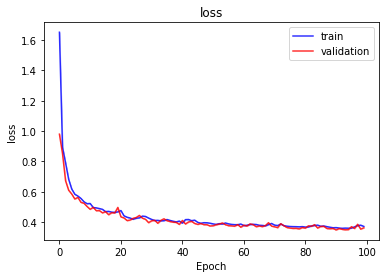

<b>bioma_loss</b>: 0.0843 (min: 0.0843, max: 0.0843)

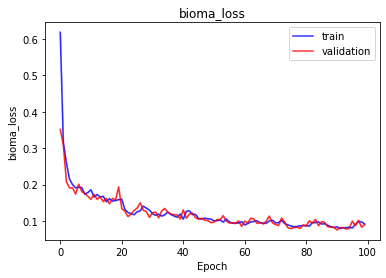

<b>domain_loss</b>: 0.2583 (min: 0.2583, max: 0.2583)

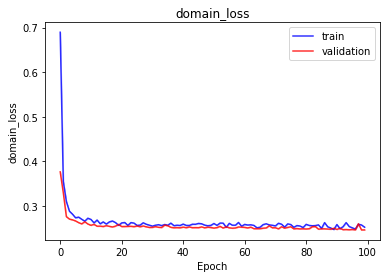

<b>latent_loss</b>: 0.0263 (min: 0.0263, max: 0.0263)

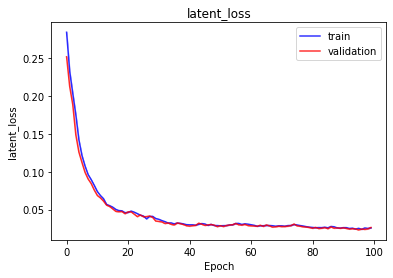

<b>bioma_mse</b>: 0.0001 (min: 0.0001, max: 0.0001)

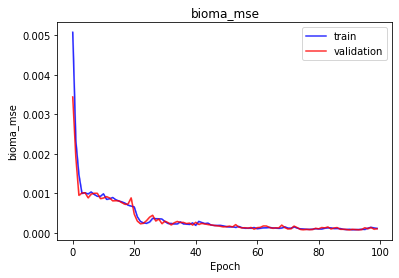

<b>bioma_mae</b>: 0.0029 (min: 0.0029, max: 0.0029)

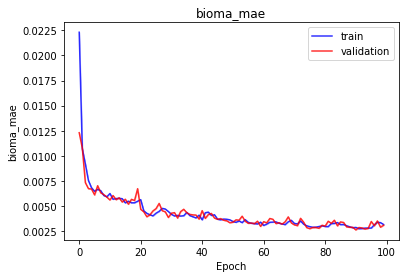

<b>bioma_mape</b>: 2301.1863 (min: 2301.1863, max: 2301.1863)

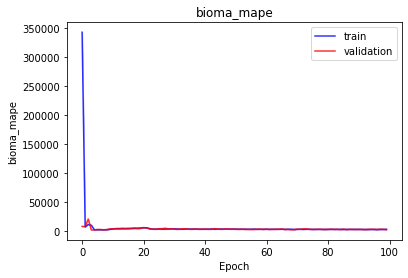

<b>bioma_BrayCurtis</b>: 0.0837 (min: 0.0837, max: 0.0837)

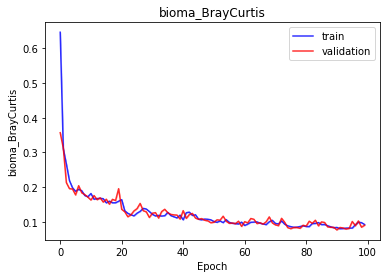

<b>bioma_pearson_corr</b>: 0.9927 (min: 0.9927, max: 0.9927)

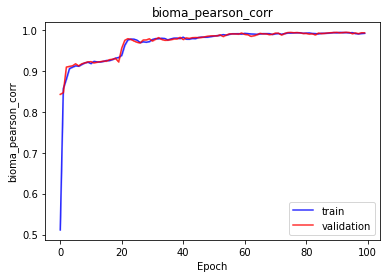

<b>bioma_jensen_shannon_divergence</b>: 0.0990 (min: 0.0990, max: 0.0990)

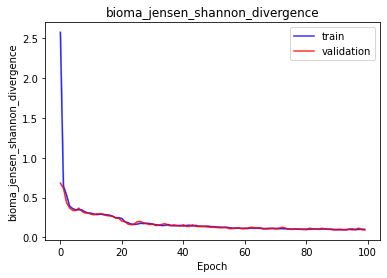

<b>domain_mse</b>: 0.0018 (min: 0.0018, max: 0.0018)

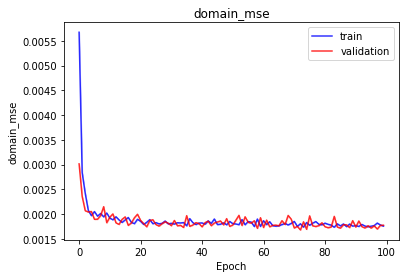

<b>domain_mae</b>: 0.0088 (min: 0.0088, max: 0.0088)

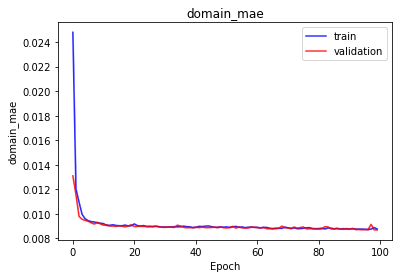

<b>domain_mape</b>: 2235.3704 (min: 2235.3704, max: 2235.3704)

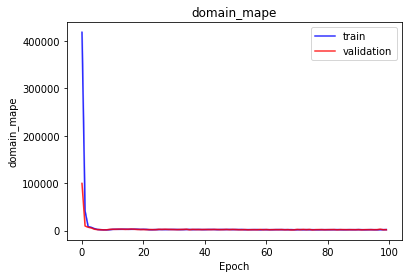

<b>domain_BrayCurtis</b>: 0.2542 (min: 0.2542, max: 0.2542)

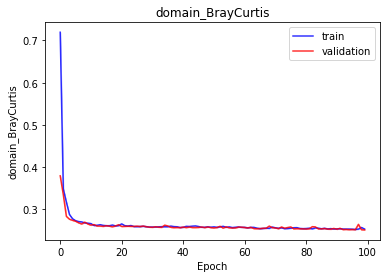

<b>domain_pearson_corr</b>: 0.8738 (min: 0.8738, max: 0.8738)

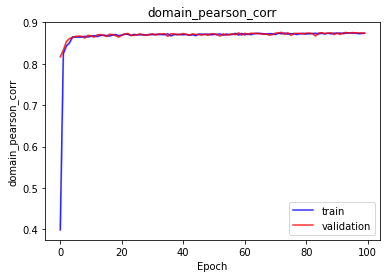

<b>domain_jensen_shannon_divergence</b>: 0.4235 (min: 0.4235, max: 0.4235)

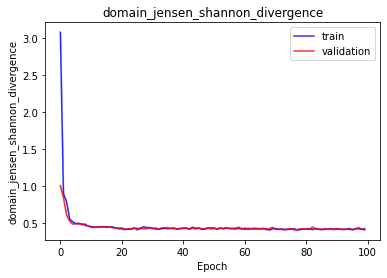

<b>latent_mae</b>: 0.0261 (min: 0.0261, max: 0.0261)

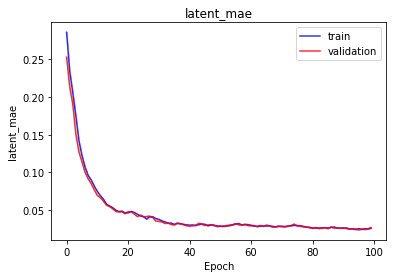

| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| loss | 0.3640660253854898 | 0.3640660253854898 | 0.3640660253854898 |
| bioma_loss | 0.08426108956336975 | 0.08426108956336975 | 0.08426108956336975 |
| domain_loss | 0.2583351135253906 | 0.2583351135253906 | 0.2583351135253906 |
| latent_loss | 0.02627241052687168 | 0.02627241052687168 | 0.02627241052687168 |
| bioma_mse | 8.90665251063183e-05 | 8.90665251063183e-05 | 8.90665251063183e-05 |
| bioma_mae | 0.002886192873120308 | 0.002886192873120308 | 0.002886192873120308 |
| bioma_mape | 2301.186279296875 | 2301.186279296875 | 2301.186279296875 |
| bioma_BrayCurtis | 0.08369716256856918 | 0.08369716256856918 | 0.08369716256856918 |
| bioma_pearson_corr | 0.9927197694778442 | 0.9927197694778442 | 0.9927197694778442 |
| bioma_jensen_shannon_divergence | 0.09904173016548157 | 0.09904173016548157 | 0.09904173016548157 |
| domain_mse | 0.0017658788710832596 | 0.0017658788710832596 | 0.0017658788710832596 |
| domain_mae | 0.00876650121062994 | 0.00876650121062994 | 0.00876650121062994 |
| domain_mape | 2235.370361328125 | 2235.370361328125 | 2235.370361328125 |
| domain_BrayCurtis | 0.25422120094299316 | 0.25422120094299316 | 0.25422120094299316 |
| domain_pearson_corr | 0.8738160729408264 | 0.8738160729408264 | 0.8738160729408264 |
| domain_jensen_shannon_divergence | 0.4234829843044281 | 0.4234829843044281 | 0.4234829843044281 |
| latent_mae | 0.026147671043872833 | 0.026147671043872833 | 0.026147671043872833 |


*************

## Test results 
| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| BrayCurtis | 0.2879648506641388 | 0.2879648506641388 | 0.2879648506641388 |
| pearson_corr | 0.8644165396690369 | 0.8644165396690369 | 0.8644165396690369 |
| jensen_shannon_divergence | 0.4332495629787445 | 0.4332495629787445 | 0.4332495629787445 |


In [19]:
#Cargamos los datos
#nombres_metadatos = ["KCAL","PROT","TFAT","CARB","MOIS","ALC","CAFF","THEO","SUGR","FIBE","CALC","IRON","MAGN","PHOS","POTA","SODI","ZINC","COPP","SELE","VC","VB1","VB2","NIAC","VB6","FOLA","VB12","VARA","RET","BCAR","ACAR","CRYP","LYCO","LZ","ATOC","VK","CHOLE","SFAT","MFAT","PFAT","VITD","CHOLN"]
nombres_metadatos = ["PROT","TFAT","CARB","MOIS","ALC","CAFF","THEO","CALC","MAGN","POTA","ZINC","VC","VB1","VB6","VARA","ACAR","CRYP","LYCO","ATOC","VK","CHOLE","VITD"]
df_microbioma_train, df_microbioma_test, _, _, \
df_domain_train, df_domain_test, _, _, otu_columns, domain_columns = read_df(metadata_names=nombres_metadatos,otu_filename='resultados_ana/nuevos_datos/arreglados/otu_table_Family.csv',metadata_filename='resultados_ana/datos_otus_metadatos_especies/metadatos_nutrientes.csv')

data_microbioma_train = df_microbioma_train.to_numpy(dtype=np.float32)
data_microbioma_test = df_microbioma_test.to_numpy(dtype=np.float32)
data_domain_train = df_domain_train.to_numpy(dtype=np.float32)
data_domain_test = df_domain_test.to_numpy(dtype=np.float32)

experiment_metrics, models, results = perform_experiment_2_mod(cv_folds=0,
                                                               epochs=100,
                                                               batch_size=64,
                                                               learning_rate=0.001,
                                                               optimizer=optimizers.Adam,
                                                               learning_rate_scheduler=None,
                                                               input_transform=Percentage,
                                                               output_transform=tf.keras.layers.Softmax,
                                                               reconstruction_loss=MakeLoss(LossBrayCurtis, Percentage, None),
                                                               latent_space=15,
                                                               layers=[512,256,128],
                                                               activation='tanh',
                                                               activation_latent='tanh',
                                                               data_microbioma_train=data_microbioma_train,
                                                               data_domain_train=data_domain_train,
                                                               show_results=True,
                                                               device='/CPU:0')
    
#Guardamos el modelo, encoder y decoder
model, encoder, _ ,decoder = models[0]
  
def model_fn_latent():
    in_layer = layers.Input(shape=(data_domain_train.shape[1],))
    net = layers.Dense(128, activation='tanh')(in_layer)
    net = layers.Dense(64, activation='tanh')(net)
    net = layers.Dense(32, activation='tanh')(net)
    net = layers.Dense(16, activation='tanh')(net)
    out_layer = layers.Dense(latent_train.shape[1], activation='tanh')(net)
    model = keras.Model(inputs=[in_layer], outputs=[out_layer], name='model')
    model.compile(optimizer=optimizers.Adam(lr=0.001), loss=tf.keras.losses.MeanSquaredError(), metrics=[tf.keras.metrics.MeanSquaredError()])
    return model
    
#funcion del modelado -- por ahora lo dejaremos asi, y voy a habalr con ella par aver que cambio, que tuneo
latent_train = encoder.predict(data_microbioma_train)
    
result_latent, model_latent = train_tl_noEnsemble(model_fn_latent,
                                                  latent_train,
                                                  latent_train,
                                                  data_domain_train,
                                                  data_domain_train,
                                                  epochs=100,
                                                  batch_size=16,
                                                  verbose=-1)

#evaluamos el modelo
latent_test = encoder.predict(data_microbioma_test)
predictions = test_model_tl_noEnsemble(model_latent, decoder, Percentage, tf.keras.layers.Softmax, otu_columns, data_microbioma_test, data_domain_test)


encoder_biome = encoder
encoder_domain = model_latent

#run prediction test set from domain, i.e., diet features
# Input only domain (i.e. environmental features)
pred_latent = encoder_domain.predict(data_dietas_nuevas)
pred_domain = decoder.predict(pred_latent)

df_pred_otu, df_pred_latent = save_predicted_otu_table_and_latent(pred_domain,pred_latent,dietas_nuevas.index,df_microbioma_test.columns,'predFromDomain_CombinedNutrientes22DietasNuevas_familia')

| Parameter             | Value         |
|:----------------------|:--------------|
| Input transform | Percentage |
| Output transform | Softmax |
| Reconstruction Loss | LossBrayCurtis |
| Latent Space | 15 |
| Bioma Autoencoder | b -> 512 -> 256 -> 128 -> 15 -> 128 -> 256 -> 512 -> b |
| Domain Autoencoder | d -> 32 -> 16 -> 8 -> 15 -> 128 -> 256 -> 512 -> b |
| Activation Encoder | tanh |
| Activation Decoder | tanh |
| Activation Latent | tanh |
| CV folds | 0 |
| Epochs | 100 |
| Batch Size | 64 |
| Learning Rate Scheduler | none |
| Learning Rate | constant = 0.001 |
| Optimizer | Adam |


<p>Best iteration: <b>94</b></p>

<b>loss</b>: 0.1497 (min: 0.1497, max: 0.1497)

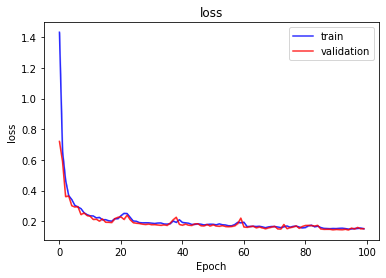

<b>bioma_loss</b>: 0.0364 (min: 0.0364, max: 0.0364)

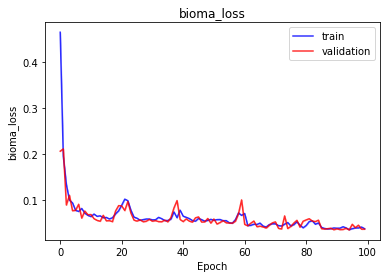

<b>domain_loss</b>: 0.0994 (min: 0.0994, max: 0.0994)

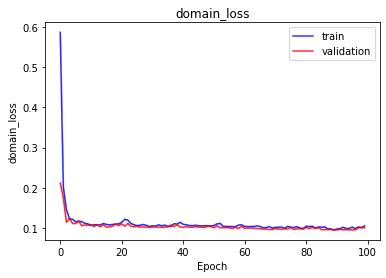

<b>latent_loss</b>: 0.0127 (min: 0.0127, max: 0.0127)

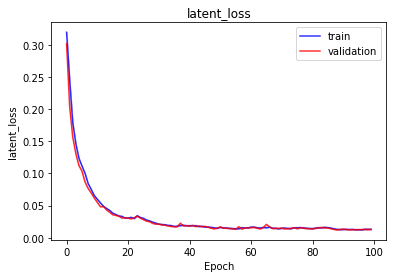

<b>bioma_mse</b>: 0.0001 (min: 0.0001, max: 0.0001)

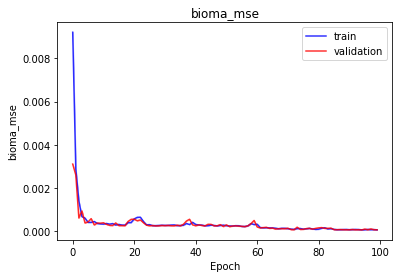

<b>bioma_mae</b>: 0.0023 (min: 0.0023, max: 0.0023)

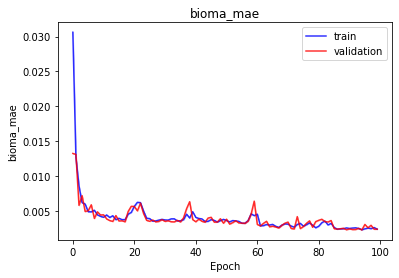

<b>bioma_mape</b>: 2819.2986 (min: 2819.2986, max: 2819.2986)

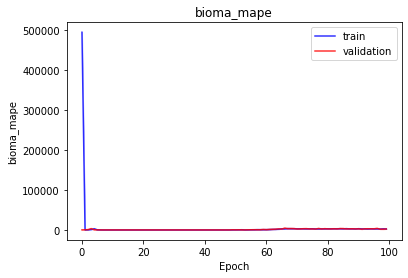

<b>bioma_BrayCurtis</b>: 0.0366 (min: 0.0366, max: 0.0366)

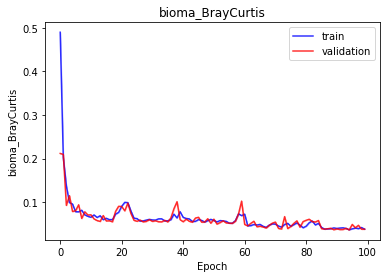

<b>bioma_pearson_corr</b>: 0.9978 (min: 0.9978, max: 0.9978)

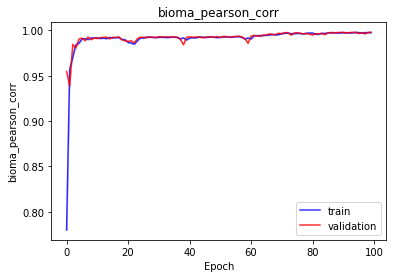

<b>bioma_jensen_shannon_divergence</b>: 0.0491 (min: 0.0491, max: 0.0491)

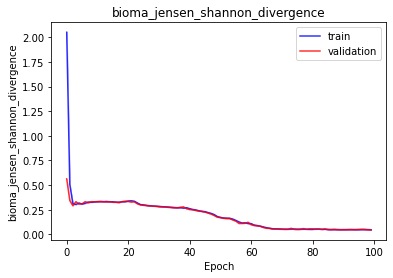

<b>domain_mse</b>: 0.0009 (min: 0.0009, max: 0.0009)

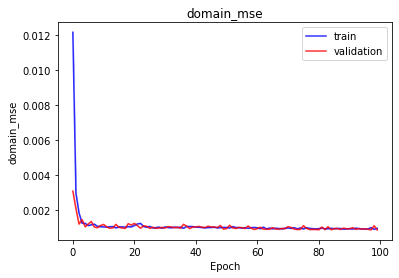

<b>domain_mae</b>: 0.0063 (min: 0.0063, max: 0.0063)

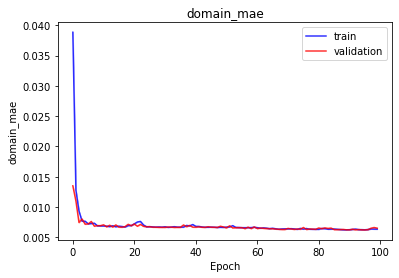

<b>domain_mape</b>: 2325.9382 (min: 2325.9382, max: 2325.9382)

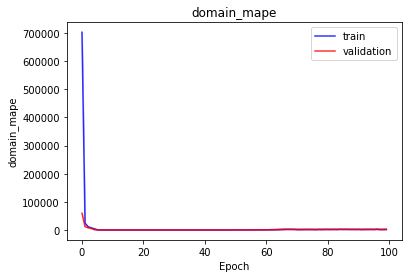

<b>domain_BrayCurtis</b>: 0.1002 (min: 0.1002, max: 0.1002)

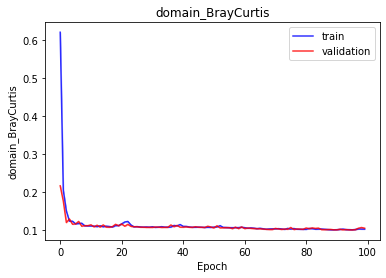

<b>domain_pearson_corr</b>: 0.9778 (min: 0.9778, max: 0.9778)

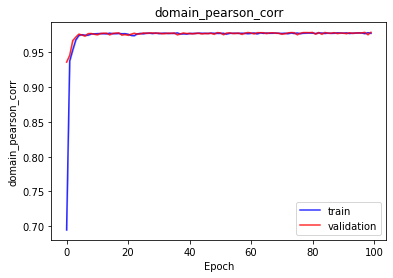

<b>domain_jensen_shannon_divergence</b>: 0.1029 (min: 0.1029, max: 0.1029)

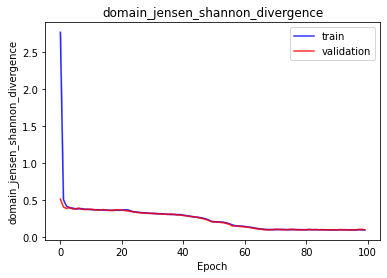

<b>latent_mae</b>: 0.0128 (min: 0.0128, max: 0.0128)

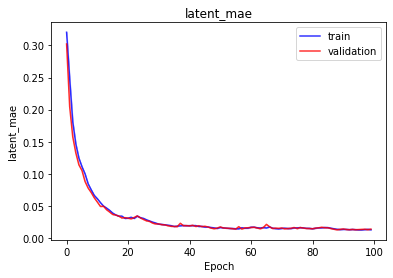

| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| loss | 0.14970888159213921 | 0.14970888159213921 | 0.14970888159213921 |
| bioma_loss | 0.036352988332509995 | 0.036352988332509995 | 0.036352988332509995 |
| domain_loss | 0.09943391382694244 | 0.09943391382694244 | 0.09943391382694244 |
| latent_loss | 0.012721491046249866 | 0.012721491046249866 | 0.012721491046249866 |
| bioma_mse | 7.215105870272964e-05 | 7.215105870272964e-05 | 7.215105870272964e-05 |
| bioma_mae | 0.0022903024218976498 | 0.0022903024218976498 | 0.0022903024218976498 |
| bioma_mape | 2819.298583984375 | 2819.298583984375 | 2819.298583984375 |
| bioma_BrayCurtis | 0.03664425015449524 | 0.03664425015449524 | 0.03664425015449524 |
| bioma_pearson_corr | 0.9978410601615906 | 0.9978410601615906 | 0.9978410601615906 |
| bioma_jensen_shannon_divergence | 0.04913932457566261 | 0.04913932457566261 | 0.04913932457566261 |
| domain_mse | 0.0009312881738878787 | 0.0009312881738878787 | 0.0009312881738878787 |
| domain_mae | 0.006265672389417887 | 0.006265672389417887 | 0.006265672389417887 |
| domain_mape | 2325.938232421875 | 2325.938232421875 | 2325.938232421875 |
| domain_BrayCurtis | 0.10024915635585785 | 0.10024915635585785 | 0.10024915635585785 |
| domain_pearson_corr | 0.9778178930282593 | 0.9778178930282593 | 0.9778178930282593 |
| domain_jensen_shannon_divergence | 0.10294248163700104 | 0.10294248163700104 | 0.10294248163700104 |
| latent_mae | 0.012815467081964016 | 0.012815467081964016 | 0.012815467081964016 |


*************

## Test results 
| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| BrayCurtis | 0.11568769812583923 | 0.11568769812583923 | 0.11568769812583923 |
| pearson_corr | 0.9787090420722961 | 0.9787090420722961 | 0.9787090420722961 |
| jensen_shannon_divergence | 0.10964465886354446 | 0.10964465886354446 | 0.10964465886354446 |


In [20]:
#Cargamos los datos
#nombres_metadatos = ["KCAL","PROT","TFAT","CARB","MOIS","ALC","CAFF","THEO","SUGR","FIBE","CALC","IRON","MAGN","PHOS","POTA","SODI","ZINC","COPP","SELE","VC","VB1","VB2","NIAC","VB6","FOLA","VB12","VARA","RET","BCAR","ACAR","CRYP","LYCO","LZ","ATOC","VK","CHOLE","SFAT","MFAT","PFAT","VITD","CHOLN"]
nombres_metadatos = ["PROT","TFAT","CARB","MOIS","ALC","CAFF","THEO","CALC","MAGN","POTA","ZINC","VC","VB1","VB6","VARA","ACAR","CRYP","LYCO","ATOC","VK","CHOLE","VITD"]
df_microbioma_train, df_microbioma_test, _, _, \
df_domain_train, df_domain_test, _, _, otu_columns, domain_columns = read_df(metadata_names=nombres_metadatos,otu_filename='resultados_ana/nuevos_datos/arreglados/otu_table_Order.csv',metadata_filename='resultados_ana/datos_otus_metadatos_especies/metadatos_nutrientes.csv')

data_microbioma_train = df_microbioma_train.to_numpy(dtype=np.float32)
data_microbioma_test = df_microbioma_test.to_numpy(dtype=np.float32)
data_domain_train = df_domain_train.to_numpy(dtype=np.float32)
data_domain_test = df_domain_test.to_numpy(dtype=np.float32)

experiment_metrics, models, results = perform_experiment_2_mod(cv_folds=0,
                                                               epochs=100,
                                                               batch_size=64,
                                                               learning_rate=0.001,
                                                               optimizer=optimizers.Adam,
                                                               learning_rate_scheduler=None,
                                                               input_transform=Percentage,
                                                               output_transform=tf.keras.layers.Softmax,
                                                               reconstruction_loss=MakeLoss(LossBrayCurtis, Percentage, None),
                                                               latent_space=15,
                                                               layers=[512,256,128],
                                                               activation='tanh',
                                                               activation_latent='tanh',
                                                               data_microbioma_train=data_microbioma_train,
                                                               data_domain_train=data_domain_train,
                                                               show_results=True,
                                                               device='/CPU:0')
    
#Guardamos el modelo, encoder y decoder
model, encoder, _ ,decoder = models[0]
  
def model_fn_latent():
    in_layer = layers.Input(shape=(data_domain_train.shape[1],))
    net = layers.Dense(128, activation='tanh')(in_layer)
    net = layers.Dense(64, activation='tanh')(net)
    net = layers.Dense(32, activation='tanh')(net)
    net = layers.Dense(16, activation='tanh')(net)
    out_layer = layers.Dense(latent_train.shape[1], activation='tanh')(net)
    model = keras.Model(inputs=[in_layer], outputs=[out_layer], name='model')
    model.compile(optimizer=optimizers.Adam(lr=0.001), loss=tf.keras.losses.MeanSquaredError(), metrics=[tf.keras.metrics.MeanSquaredError()])
    return model
    
#funcion del modelado -- por ahora lo dejaremos asi, y voy a habalr con ella par aver que cambio, que tuneo
latent_train = encoder.predict(data_microbioma_train)
    
result_latent, model_latent = train_tl_noEnsemble(model_fn_latent,
                                                  latent_train,
                                                  latent_train,
                                                  data_domain_train,
                                                  data_domain_train,
                                                  epochs=100,
                                                  batch_size=16,
                                                  verbose=-1)

#evaluamos el modelo
latent_test = encoder.predict(data_microbioma_test)
predictions = test_model_tl_noEnsemble(model_latent, decoder, Percentage, tf.keras.layers.Softmax, otu_columns, data_microbioma_test, data_domain_test)

encoder_biome = encoder
encoder_domain = model_latent

#run prediction test set from domain, i.e., diet features
# Input only domain (i.e. environmental features)
pred_latent = encoder_domain.predict(data_dietas_nuevas)
pred_domain = decoder.predict(pred_latent)

df_pred_otu, df_pred_latent = save_predicted_otu_table_and_latent(pred_domain,pred_latent,dietas_nuevas.index,df_microbioma_test.columns,'predFromDomain_CombinedNutrientes22DietasNuevas_orden')

| Parameter             | Value         |
|:----------------------|:--------------|
| Input transform | Percentage |
| Output transform | Softmax |
| Reconstruction Loss | LossBrayCurtis |
| Latent Space | 15 |
| Bioma Autoencoder | b -> 512 -> 256 -> 128 -> 15 -> 128 -> 256 -> 512 -> b |
| Domain Autoencoder | d -> 32 -> 16 -> 8 -> 15 -> 128 -> 256 -> 512 -> b |
| Activation Encoder | tanh |
| Activation Decoder | tanh |
| Activation Latent | tanh |
| CV folds | 0 |
| Epochs | 100 |
| Batch Size | 64 |
| Learning Rate Scheduler | none |
| Learning Rate | constant = 0.001 |
| Optimizer | Adam |


<p>Best iteration: <b>71</b></p>

<b>loss</b>: 0.1524 (min: 0.1524, max: 0.1524)

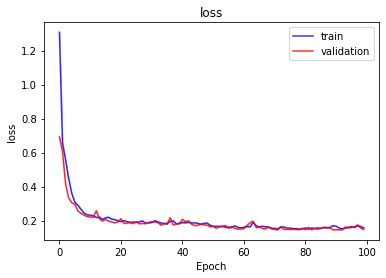

<b>bioma_loss</b>: 0.0371 (min: 0.0371, max: 0.0371)

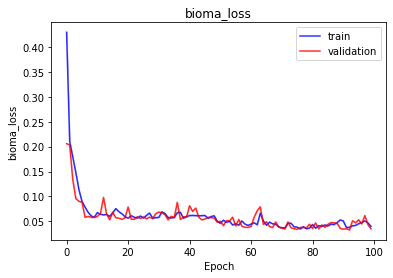

<b>domain_loss</b>: 0.1012 (min: 0.1012, max: 0.1012)

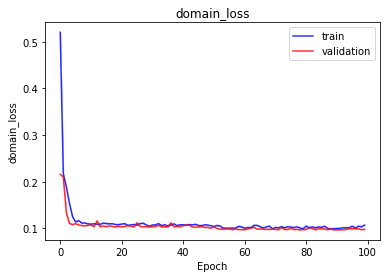

<b>latent_loss</b>: 0.0143 (min: 0.0143, max: 0.0143)

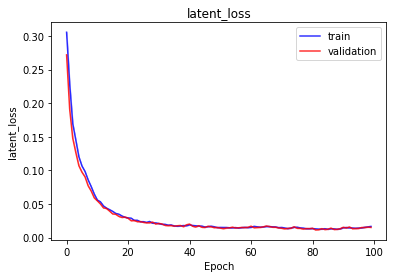

<b>bioma_mse</b>: 0.0001 (min: 0.0001, max: 0.0001)

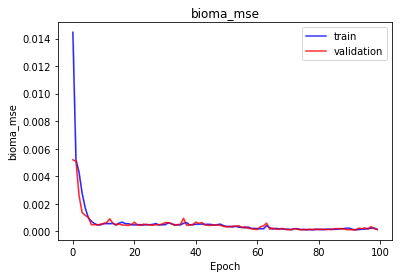

<b>bioma_mae</b>: 0.0039 (min: 0.0039, max: 0.0039)

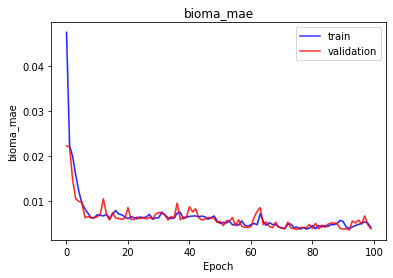

<b>bioma_mape</b>: 3449.3293 (min: 3449.3293, max: 3449.3293)

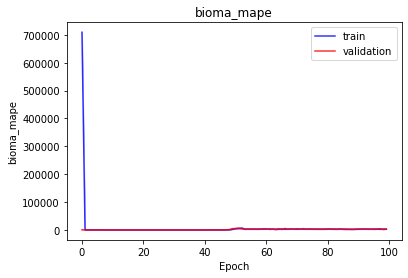

<b>bioma_BrayCurtis</b>: 0.0367 (min: 0.0367, max: 0.0367)

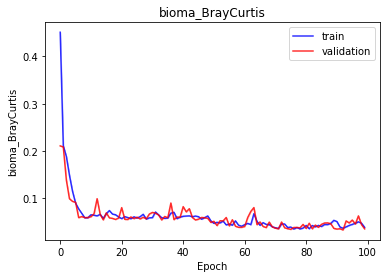

<b>bioma_pearson_corr</b>: 0.9975 (min: 0.9975, max: 0.9975)

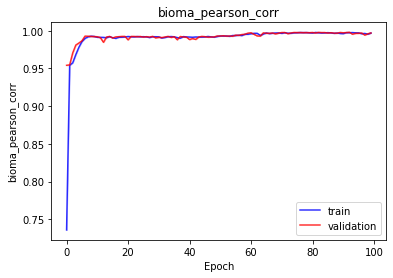

<b>bioma_jensen_shannon_divergence</b>: 0.0448 (min: 0.0448, max: 0.0448)

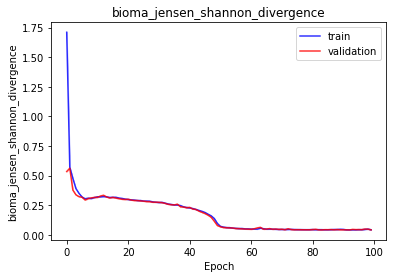

<b>domain_mse</b>: 0.0016 (min: 0.0016, max: 0.0016)

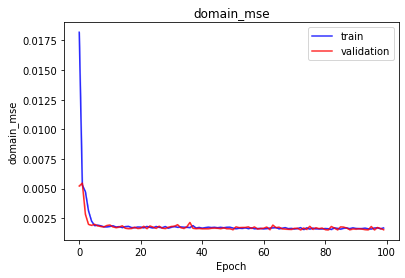

<b>domain_mae</b>: 0.0107 (min: 0.0107, max: 0.0107)

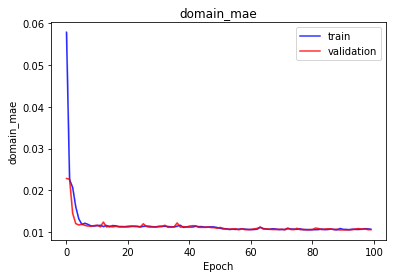

<b>domain_mape</b>: 2582.0916 (min: 2582.0916, max: 2582.0916)

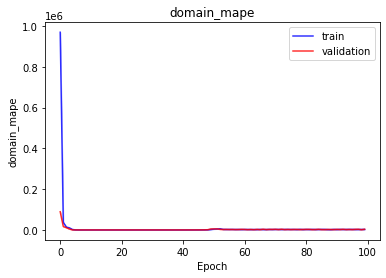

<b>domain_BrayCurtis</b>: 0.1015 (min: 0.1015, max: 0.1015)

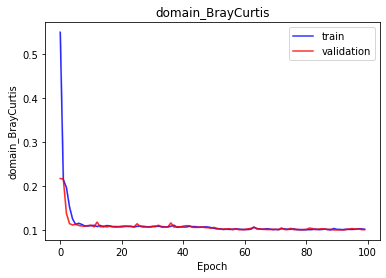

<b>domain_pearson_corr</b>: 0.9765 (min: 0.9765, max: 0.9765)

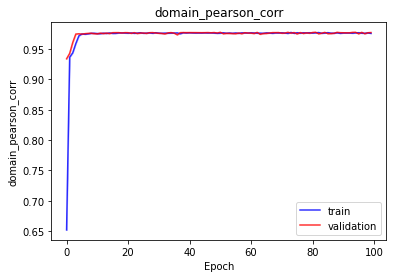

<b>domain_jensen_shannon_divergence</b>: 0.0998 (min: 0.0998, max: 0.0998)

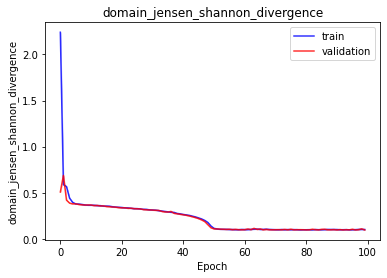

<b>latent_mae</b>: 0.0142 (min: 0.0142, max: 0.0142)

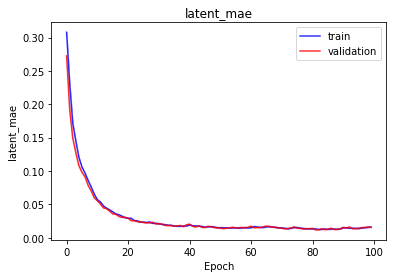

| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| loss | 0.15237900882195204 | 0.15237900882195204 | 0.15237900882195204 |
| bioma_loss | 0.037117693573236465 | 0.037117693573236465 | 0.037117693573236465 |
| domain_loss | 0.10123686492443085 | 0.10123686492443085 | 0.10123686492443085 |
| latent_loss | 0.014254532754421234 | 0.014254532754421234 | 0.014254532754421234 |
| bioma_mse | 0.00012800726108253002 | 0.00012800726108253002 | 0.00012800726108253002 |
| bioma_mae | 0.0038641986902803183 | 0.0038641986902803183 | 0.0038641986902803183 |
| bioma_mape | 3449.329345703125 | 3449.329345703125 | 3449.329345703125 |
| bioma_BrayCurtis | 0.036709532141685486 | 0.036709532141685486 | 0.036709532141685486 |
| bioma_pearson_corr | 0.9974749088287354 | 0.9974749088287354 | 0.9974749088287354 |
| bioma_jensen_shannon_divergence | 0.044801633805036545 | 0.044801633805036545 | 0.044801633805036545 |
| domain_mse | 0.0016245946753770113 | 0.0016245946753770113 | 0.0016245946753770113 |
| domain_mae | 0.010681566782295704 | 0.010681566782295704 | 0.010681566782295704 |
| domain_mape | 2582.091552734375 | 2582.091552734375 | 2582.091552734375 |
| domain_BrayCurtis | 0.10147391259670258 | 0.10147391259670258 | 0.10147391259670258 |
| domain_pearson_corr | 0.976517915725708 | 0.976517915725708 | 0.976517915725708 |
| domain_jensen_shannon_divergence | 0.09978622943162918 | 0.09978622943162918 | 0.09978622943162918 |
| latent_mae | 0.014195562340319157 | 0.014195562340319157 | 0.014195562340319157 |


*************

## Test results 
| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| BrayCurtis | 0.11322373896837234 | 0.11322373896837234 | 0.11322373896837234 |
| pearson_corr | 0.9789550304412842 | 0.9789550304412842 | 0.9789550304412842 |
| jensen_shannon_divergence | 0.10197793692350388 | 0.10197793692350388 | 0.10197793692350388 |


In [21]:
#Cargamos los datos
#nombres_metadatos = ["KCAL","PROT","TFAT","CARB","MOIS","ALC","CAFF","THEO","SUGR","FIBE","CALC","IRON","MAGN","PHOS","POTA","SODI","ZINC","COPP","SELE","VC","VB1","VB2","NIAC","VB6","FOLA","VB12","VARA","RET","BCAR","ACAR","CRYP","LYCO","LZ","ATOC","VK","CHOLE","SFAT","MFAT","PFAT","VITD","CHOLN"]
nombres_metadatos = ["PROT","TFAT","CARB","MOIS","ALC","CAFF","THEO","CALC","MAGN","POTA","ZINC","VC","VB1","VB6","VARA","ACAR","CRYP","LYCO","ATOC","VK","CHOLE","VITD"]
df_microbioma_train, df_microbioma_test, _, _, \
df_domain_train, df_domain_test, _, _, otu_columns, domain_columns = read_df(metadata_names=nombres_metadatos,otu_filename='resultados_ana/nuevos_datos/arreglados/otu_table_Class.csv',metadata_filename='resultados_ana/datos_otus_metadatos_especies/metadatos_nutrientes.csv')

data_microbioma_train = df_microbioma_train.to_numpy(dtype=np.float32)
data_microbioma_test = df_microbioma_test.to_numpy(dtype=np.float32)
data_domain_train = df_domain_train.to_numpy(dtype=np.float32)
data_domain_test = df_domain_test.to_numpy(dtype=np.float32)

experiment_metrics, models, results = perform_experiment_2_mod(cv_folds=0,
                                                               epochs=100,
                                                               batch_size=64,
                                                               learning_rate=0.001,
                                                               optimizer=optimizers.Adam,
                                                               learning_rate_scheduler=None,
                                                               input_transform=Percentage,
                                                               output_transform=tf.keras.layers.Softmax,
                                                               reconstruction_loss=MakeLoss(LossBrayCurtis, Percentage, None),
                                                               latent_space=15,
                                                               layers=[512,256,128],
                                                               activation='tanh',
                                                               activation_latent='tanh',
                                                               data_microbioma_train=data_microbioma_train,
                                                               data_domain_train=data_domain_train,
                                                               show_results=True,
                                                               device='/CPU:0')
    
#Guardamos el modelo, encoder y decoder
model, encoder, _ ,decoder = models[0]
  
def model_fn_latent():
    in_layer = layers.Input(shape=(data_domain_train.shape[1],))
    net = layers.Dense(128, activation='tanh')(in_layer)
    net = layers.Dense(64, activation='tanh')(net)
    net = layers.Dense(32, activation='tanh')(net)
    net = layers.Dense(16, activation='tanh')(net)
    out_layer = layers.Dense(latent_train.shape[1], activation='tanh')(net)
    model = keras.Model(inputs=[in_layer], outputs=[out_layer], name='model')
    model.compile(optimizer=optimizers.Adam(lr=0.001), loss=tf.keras.losses.MeanSquaredError(), metrics=[tf.keras.metrics.MeanSquaredError()])
    return model
    
#funcion del modelado -- por ahora lo dejaremos asi, y voy a habalr con ella par aver que cambio, que tuneo
latent_train = encoder.predict(data_microbioma_train)
    
result_latent, model_latent = train_tl_noEnsemble(model_fn_latent,
                                                  latent_train,
                                                  latent_train,
                                                  data_domain_train,
                                                  data_domain_train,
                                                  epochs=100,
                                                  batch_size=16,
                                                  verbose=-1)

#evaluamos el modelo
latent_test = encoder.predict(data_microbioma_test)
predictions = test_model_tl_noEnsemble(model_latent, decoder, Percentage, tf.keras.layers.Softmax, otu_columns, data_microbioma_test, data_domain_test)

encoder_biome = encoder
encoder_domain = model_latent

#run prediction test set from domain, i.e., diet features
# Input only domain (i.e. environmental features)
pred_latent = encoder_domain.predict(data_dietas_nuevas)
pred_domain = decoder.predict(pred_latent)

df_pred_otu, df_pred_latent = save_predicted_otu_table_and_latent(pred_domain,pred_latent,dietas_nuevas.index,df_microbioma_test.columns,'predFromDomain_CombinedNutrientes22DietasNuevas_clase')

| Parameter             | Value         |
|:----------------------|:--------------|
| Input transform | Percentage |
| Output transform | Softmax |
| Reconstruction Loss | LossBrayCurtis |
| Latent Space | 15 |
| Bioma Autoencoder | b -> 512 -> 256 -> 128 -> 15 -> 128 -> 256 -> 512 -> b |
| Domain Autoencoder | d -> 32 -> 16 -> 8 -> 15 -> 128 -> 256 -> 512 -> b |
| Activation Encoder | tanh |
| Activation Decoder | tanh |
| Activation Latent | tanh |
| CV folds | 0 |
| Epochs | 100 |
| Batch Size | 64 |
| Learning Rate Scheduler | none |
| Learning Rate | constant = 0.001 |
| Optimizer | Adam |


<p>Best iteration: <b>84</b></p>

<b>loss</b>: 0.1460 (min: 0.1460, max: 0.1460)

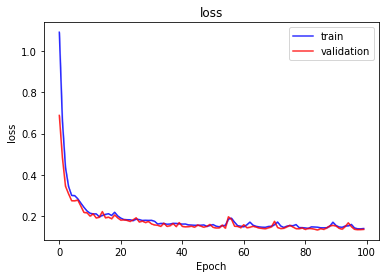

<b>bioma_loss</b>: 0.0337 (min: 0.0337, max: 0.0337)

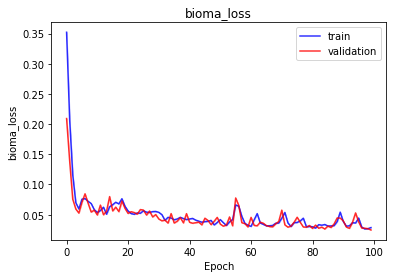

<b>domain_loss</b>: 0.0993 (min: 0.0993, max: 0.0993)

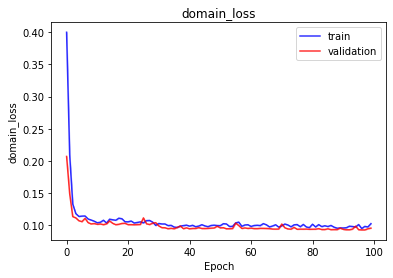

<b>latent_loss</b>: 0.0144 (min: 0.0144, max: 0.0144)

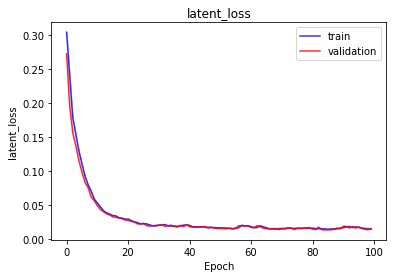

<b>bioma_mse</b>: 0.0003 (min: 0.0003, max: 0.0003)

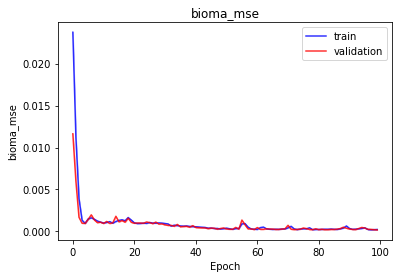

<b>bioma_mae</b>: 0.0075 (min: 0.0075, max: 0.0075)

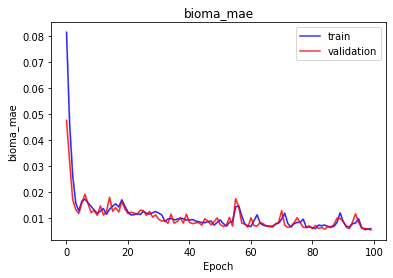

<b>bioma_mape</b>: 3714.3845 (min: 3714.3845, max: 3714.3845)

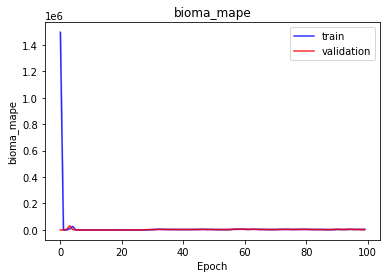

<b>bioma_BrayCurtis</b>: 0.0339 (min: 0.0339, max: 0.0339)

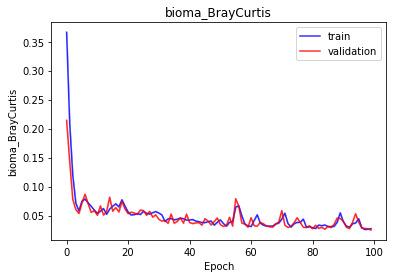

<b>bioma_pearson_corr</b>: 0.9971 (min: 0.9971, max: 0.9971)

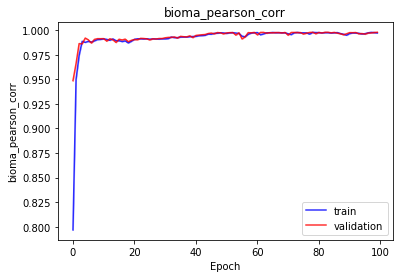

<b>bioma_jensen_shannon_divergence</b>: 0.0240 (min: 0.0240, max: 0.0240)

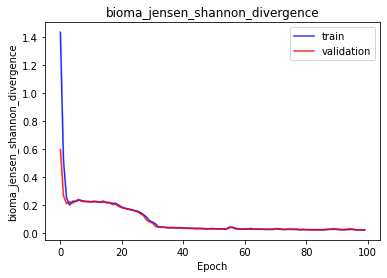

<b>domain_mse</b>: 0.0035 (min: 0.0035, max: 0.0035)

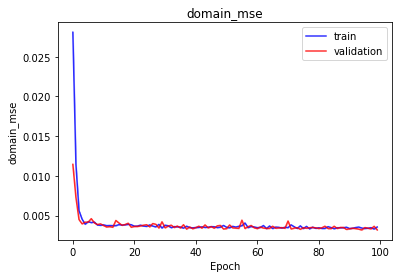

<b>domain_mae</b>: 0.0217 (min: 0.0217, max: 0.0217)

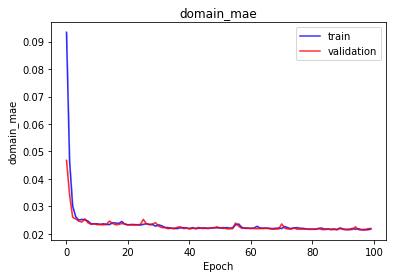

<b>domain_mape</b>: 2238.3411 (min: 2238.3411, max: 2238.3411)

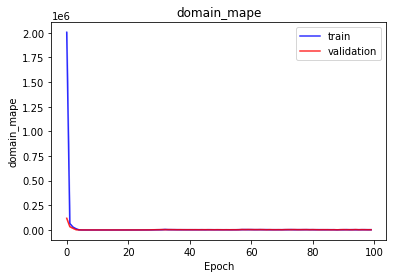

<b>domain_BrayCurtis</b>: 0.0978 (min: 0.0978, max: 0.0978)

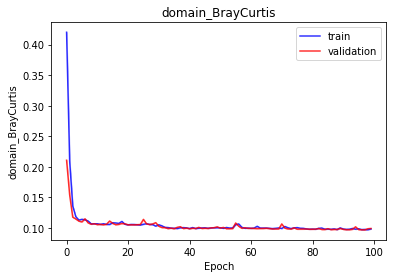

<b>domain_pearson_corr</b>: 0.9737 (min: 0.9737, max: 0.9737)

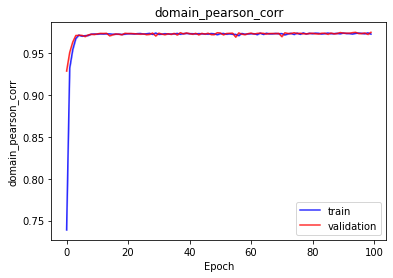

<b>domain_jensen_shannon_divergence</b>: 0.0858 (min: 0.0858, max: 0.0858)

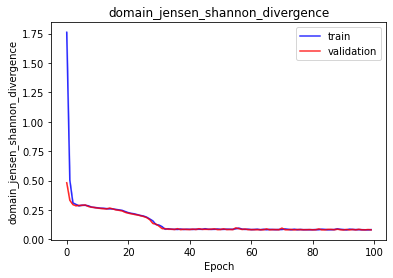

<b>latent_mae</b>: 0.0143 (min: 0.0143, max: 0.0143)

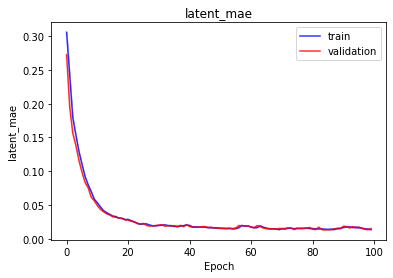

| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| loss | 0.1460215430229138 | 0.1460215430229138 | 0.1460215430229138 |
| bioma_loss | 0.03369240090250969 | 0.03369240090250969 | 0.03369240090250969 |
| domain_loss | 0.09933502227067947 | 0.09933502227067947 | 0.09933502227067947 |
| latent_loss | 0.01443616021424532 | 0.01443616021424532 | 0.01443616021424532 |
| bioma_mse | 0.0002897544763982296 | 0.0002897544763982296 | 0.0002897544763982296 |
| bioma_mae | 0.00753285875543952 | 0.00753285875543952 | 0.00753285875543952 |
| bioma_mape | 3714.384521484375 | 3714.384521484375 | 3714.384521484375 |
| bioma_BrayCurtis | 0.03389771282672882 | 0.03389771282672882 | 0.03389771282672882 |
| bioma_pearson_corr | 0.99705970287323 | 0.99705970287323 | 0.99705970287323 |
| bioma_jensen_shannon_divergence | 0.023971932008862495 | 0.023971932008862495 | 0.023971932008862495 |
| domain_mse | 0.0035000017378479242 | 0.0035000017378479242 | 0.0035000017378479242 |
| domain_mae | 0.021729517728090286 | 0.021729517728090286 | 0.021729517728090286 |
| domain_mape | 2238.341064453125 | 2238.341064453125 | 2238.341064453125 |
| domain_BrayCurtis | 0.09778238832950592 | 0.09778238832950592 | 0.09778238832950592 |
| domain_pearson_corr | 0.9736908674240112 | 0.9736908674240112 | 0.9736908674240112 |
| domain_jensen_shannon_divergence | 0.08578696846961975 | 0.08578696846961975 | 0.08578696846961975 |
| latent_mae | 0.014341440051794052 | 0.014341440051794052 | 0.014341440051794052 |


*************

## Test results 
| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| BrayCurtis | 0.10272831469774246 | 0.10272831469774246 | 0.10272831469774246 |
| pearson_corr | 0.9793490171432495 | 0.9793490171432495 | 0.9793490171432495 |
| jensen_shannon_divergence | 0.07718849927186966 | 0.07718849927186966 | 0.07718849927186966 |


In [22]:
#Cargamos los datos
#nombres_metadatos = ["KCAL","PROT","TFAT","CARB","MOIS","ALC","CAFF","THEO","SUGR","FIBE","CALC","IRON","MAGN","PHOS","POTA","SODI","ZINC","COPP","SELE","VC","VB1","VB2","NIAC","VB6","FOLA","VB12","VARA","RET","BCAR","ACAR","CRYP","LYCO","LZ","ATOC","VK","CHOLE","SFAT","MFAT","PFAT","VITD","CHOLN"]
nombres_metadatos = ["PROT","TFAT","CARB","MOIS","ALC","CAFF","THEO","CALC","MAGN","POTA","ZINC","VC","VB1","VB6","VARA","ACAR","CRYP","LYCO","ATOC","VK","CHOLE","VITD"]
df_microbioma_train, df_microbioma_test, _, _, \
df_domain_train, df_domain_test, _, _, otu_columns, domain_columns = read_df(metadata_names=nombres_metadatos,otu_filename='resultados_ana/nuevos_datos/arreglados/otu_table_Phylum.csv',metadata_filename='resultados_ana/datos_otus_metadatos_especies/metadatos_nutrientes.csv')

data_microbioma_train = df_microbioma_train.to_numpy(dtype=np.float32)
data_microbioma_test = df_microbioma_test.to_numpy(dtype=np.float32)
data_domain_train = df_domain_train.to_numpy(dtype=np.float32)
data_domain_test = df_domain_test.to_numpy(dtype=np.float32)

experiment_metrics, models, results = perform_experiment_2_mod(cv_folds=0,
                                                               epochs=100,
                                                               batch_size=64,
                                                               learning_rate=0.001,
                                                               optimizer=optimizers.Adam,
                                                               learning_rate_scheduler=None,
                                                               input_transform=Percentage,
                                                               output_transform=tf.keras.layers.Softmax,
                                                               reconstruction_loss=MakeLoss(LossBrayCurtis, Percentage, None),
                                                               latent_space=15,
                                                               layers=[512,256,128],
                                                               activation='tanh',
                                                               activation_latent='tanh',
                                                               data_microbioma_train=data_microbioma_train,
                                                               data_domain_train=data_domain_train,
                                                               show_results=True,
                                                               device='/CPU:0')
    
#Guardamos el modelo, encoder y decoder
model, encoder, _ ,decoder = models[0]
  
def model_fn_latent():
    in_layer = layers.Input(shape=(data_domain_train.shape[1],))
    net = layers.Dense(128, activation='tanh')(in_layer)
    net = layers.Dense(64, activation='tanh')(net)
    net = layers.Dense(32, activation='tanh')(net)
    net = layers.Dense(16, activation='tanh')(net)
    out_layer = layers.Dense(latent_train.shape[1], activation='tanh')(net)
    model = keras.Model(inputs=[in_layer], outputs=[out_layer], name='model')
    model.compile(optimizer=optimizers.Adam(lr=0.001), loss=tf.keras.losses.MeanSquaredError(), metrics=[tf.keras.metrics.MeanSquaredError()])
    return model
    
#funcion del modelado -- por ahora lo dejaremos asi, y voy a habalr con ella par aver que cambio, que tuneo
latent_train = encoder.predict(data_microbioma_train)
    
result_latent, model_latent = train_tl_noEnsemble(model_fn_latent,
                                                  latent_train,
                                                  latent_train,
                                                  data_domain_train,
                                                  data_domain_train,
                                                  epochs=100,
                                                  batch_size=16,
                                                  verbose=-1)

#evaluamos el modelo
latent_test = encoder.predict(data_microbioma_test)
predictions = test_model_tl_noEnsemble(model_latent, decoder, Percentage, tf.keras.layers.Softmax, otu_columns, data_microbioma_test, data_domain_test)

encoder_biome = encoder
encoder_domain = model_latent

#run prediction test set from domain, i.e., diet features
# Input only domain (i.e. environmental features)
pred_latent = encoder_domain.predict(data_dietas_nuevas)
pred_domain = decoder.predict(pred_latent)

df_pred_otu, df_pred_latent = save_predicted_otu_table_and_latent(pred_domain,pred_latent,dietas_nuevas.index,df_microbioma_test.columns,'predFromDomain_CombinedNutrientes22DietasNuevas_filo')